In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import torch
from torch import nn

from hparams.hparams_S5G import create_hparams
from model import Model
from datasets import LJDataset, TextMelCollate
from utils import sizeof_fmt, Logger

In [2]:
!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Wed Mar 17 16:42:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:2E:00.0 Off |                  N/A |
|100%   87C    P2   171W / 250W |  10404MiB / 11016MiB |     63%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:2F:00.0 Off |                  N/A |
| 84%   

In [11]:
from parallel_wavegan.utils import download_pretrained_model
from parallel_wavegan.utils import load_model

device='cuda'
vocoder_tag = "ljspeech_parallel_wavegan.v3"

# NOTE: Sometimes download is failed due to "Permission denied". That is 
#   the limitation of google drive. Please retry after serveral hours.
vocoder = load_model(download_pretrained_model(vocoder_tag)).to(device).eval()
vocoder.remove_weight_norm()
print('done')

from parallel_wavegan.utils import read_hdf5

stats_filename = "/home/rubato/.cache/parallel_wavegan/ljspeech_parallel_wavegan.v3/stats.h5"
mean = read_hdf5(stats_filename, 'mean')
scale = read_hdf5(stats_filename, 'scale')
print('done')

done
done


In [3]:
save_dir = '/data/save/model_S5G'
logger = Logger(save_dir=save_dir, new=False)
print('done')

done


In [4]:
!ls $save_dir

data.json    save_133754  save_180000  save_230000  save_275000  save_344332
save_100000  save_135000  save_184582  save_232353  save_280000  save_345000
save_100189  save_137981  save_185000  save_235000  save_282023  save_350000
save_100481  save_138253  save_185146  save_239735  save_285000  save_353107
save_100728  save_140000  save_190000  save_239809  save_290000  save_355000
save_104221  save_145000  save_195000  save_240000  save_295000  save_360000
save_105000  save_146358  save_196835  save_242209  save_300000  save_362255
save_110000  save_147866  save_199144  save_245000  save_305000  save_363423
save_115000  save_150000  save_200000  save_247546  save_306501  save_75000
save_120000  save_151422  save_201253  save_248082  save_310000  save_80000
save_123593  save_155000  save_205000  save_250000  save_315000  save_85000
save_123671  save_160000  save_210000  save_255000  save_320000  save_90000
save_123692  save_165000  save_215000  save_258351  save_324281  save_95000
save

In [5]:
stt_hparams, tts_hparams = create_hparams()
model = Model(stt_hparams, tts_hparams)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=tts_hparams.lr, weight_decay=tts_hparams.weight_decay)

step = 363423

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.parameters()))
print(f"TTS size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_encoder.parameters()))
print(f"MelEncoder size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_decoder.parameters()))
print(f"MelDecoder size {size}")

if True:
    model, optimizer, step = logger.load(step, model, optimizer)
print(step)

print('done')

Model size 283.0MiB
TTS size 195.3MiB
MelEncoder size 65.3MiB
MelDecoder size 119.0MiB
loaded : 363423
363423
done


In [6]:
trainset = LJDataset(tts_hparams, split='train')
collate_fn = TextMelCollate(tts_hparams)
train_loader = torch.utils.data.DataLoader(trainset, num_workers=8, #tts_hparams.num_workers, 
                          shuffle=True, sampler=None, batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(train_loader)

validset = LJDataset(tts_hparams, split='valid')
valid_loader = torch.utils.data.DataLoader(validset, num_workers=tts_hparams.num_workers, 
                          shuffle=True, sampler=None, batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(valid_loader)

testset = LJDataset(tts_hparams, split='test')
test_loader = torch.utils.data.DataLoader(testset, num_workers=1, 
                          shuffle=False, sampler=None, batch_size=1, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(test_loader)

In [7]:
def to_cuda(batch):
    batch['text'] = batch['text'].cuda()
    batch['text_lengths'] = batch['text_lengths'].cuda()
    batch['mels'] = batch['mels'].cuda()
    batch['mel_lengths'] = batch['mel_lengths'].cuda()
    
    return batch

elapsed time : 0.030678462982177735


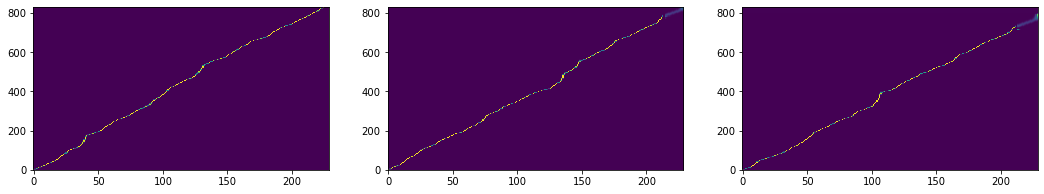

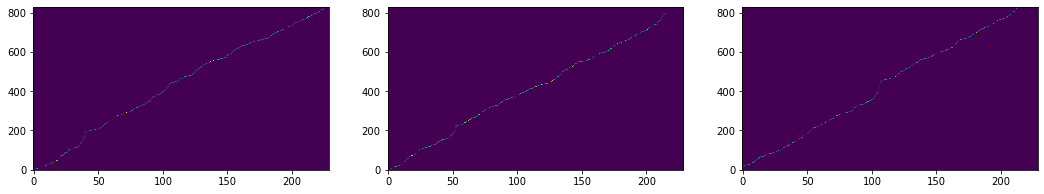

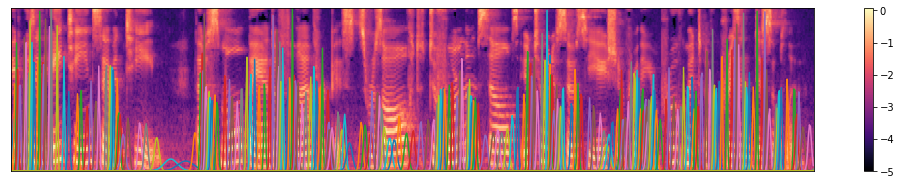

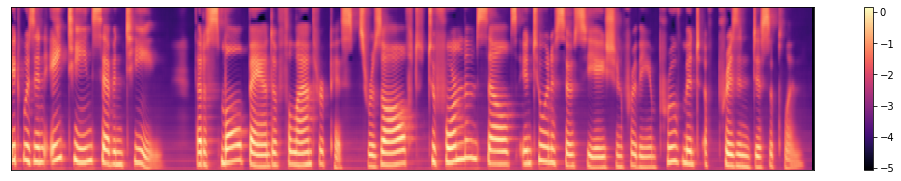

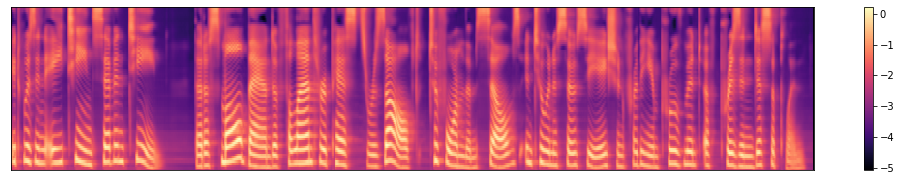

tensor(0.1245, device='cuda:0')
step : 387001 stt : 0.0006 tts : 0.1458 recon : 0.0271 kl : 0.0069 beta : 1.0000
tensor(0.1265, device='cuda:0')
step : 387002 stt : 0.0005 tts : 0.1130 recon : 0.0211 kl : 0.0057 beta : 1.0000
tensor(0.1074, device='cuda:0')
step : 387003 stt : 0.0006 tts : 0.1336 recon : 0.0247 kl : 0.0065 beta : 1.0000
tensor(0.1207, device='cuda:0')
step : 387004 stt : 0.0006 tts : 0.1321 recon : 0.0252 kl : 0.0067 beta : 1.0000
tensor(0.1598, device='cuda:0')
step : 387005 stt : 0.0006 tts : 0.1287 recon : 0.0251 kl : 0.0066 beta : 1.0000
tensor(0.1043, device='cuda:0')
step : 387006 stt : 0.0007 tts : 0.1276 recon : 0.0244 kl : 0.0065 beta : 1.0000
tensor(0.0941, device='cuda:0')
step : 387007 stt : 0.0006 tts : 0.1268 recon : 0.0254 kl : 0.0066 beta : 1.0000
tensor(0.0944, device='cuda:0')
step : 387008 stt : 0.0006 tts : 0.1299 recon : 0.0234 kl : 0.0063 beta : 1.0000
tensor(0.1007, device='cuda:0')
step : 387009 stt : 0.0012 tts : 0.1327 recon : 0.0246 kl : 0.00

tensor(0.1452, device='cuda:0')
step : 387074 stt : 0.0006 tts : 0.1268 recon : 0.0274 kl : 0.0069 beta : 1.0000
tensor(0.1180, device='cuda:0')
step : 387075 stt : 0.0006 tts : 0.1218 recon : 0.0231 kl : 0.0062 beta : 1.0000
tensor(0.1870, device='cuda:0')
step : 387076 stt : 0.0012 tts : 0.1328 recon : 0.0247 kl : 0.0063 beta : 1.0000
tensor(0.1212, device='cuda:0')
step : 387077 stt : 0.0006 tts : 0.1285 recon : 0.0243 kl : 0.0065 beta : 1.0000
tensor(0.1281, device='cuda:0')
step : 387078 stt : 0.0006 tts : 0.1196 recon : 0.0257 kl : 0.0067 beta : 1.0000
tensor(0.1224, device='cuda:0')
step : 387079 stt : 0.0005 tts : 0.1134 recon : 0.0208 kl : 0.0057 beta : 1.0000
tensor(0.0913, device='cuda:0')
step : 387080 stt : 0.0002 tts : 0.1195 recon : 0.0226 kl : 0.0060 beta : 1.0000
tensor(0.0988, device='cuda:0')
step : 387081 stt : 0.0005 tts : 0.1184 recon : 0.0222 kl : 0.0059 beta : 1.0000
tensor(0.1113, device='cuda:0')
step : 387082 stt : 0.0002 tts : 0.1186 recon : 0.0216 kl : 0.00

tensor(0.1356, device='cuda:0')
step : 387147 stt : 0.0019 tts : 0.1344 recon : 0.0245 kl : 0.0065 beta : 1.0000
tensor(0.1191, device='cuda:0')
step : 387148 stt : 0.0003 tts : 0.1251 recon : 0.0224 kl : 0.0060 beta : 1.0000
tensor(0.1046, device='cuda:0')
step : 387149 stt : 0.0007 tts : 0.1275 recon : 0.0223 kl : 0.0060 beta : 1.0000
tensor(0.0852, device='cuda:0')
step : 387150 stt : 0.0003 tts : 0.1293 recon : 0.0225 kl : 0.0060 beta : 1.0000
tensor(0.0851, device='cuda:0')
step : 387151 stt : 0.0004 tts : 0.1121 recon : 0.0238 kl : 0.0063 beta : 1.0000
tensor(0.1607, device='cuda:0')
step : 387152 stt : 0.0007 tts : 0.1246 recon : 0.0224 kl : 0.0060 beta : 1.0000
tensor(0.1475, device='cuda:0')
step : 387153 stt : 0.0014 tts : 0.1151 recon : 0.0209 kl : 0.0056 beta : 1.0000
tensor(0.1162, device='cuda:0')
step : 387154 stt : 0.0005 tts : 0.1188 recon : 0.0228 kl : 0.0062 beta : 1.0000
tensor(0.1631, device='cuda:0')
step : 387155 stt : 0.0004 tts : 0.1207 recon : 0.0222 kl : 0.00

In [ ]:
from IPython import display
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time

model.train()

while(True):
    
    for batch in train_loader:
        batch = to_cuda(batch)
        
        model.train()
        model.increase_step()
        model.zero_grad()

        stt_outputs, tts_outputs = model(batch)
        loss = tts_outputs['loss'] + stt_outputs['loss']
        loss.backward()
        
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), 1)
        print(grad_norm.mean())
        if torch.isnan(grad_norm.mean()):
            continue
        
        optimizer.step()
        
        if step % 5000 == 0:
            logger.save(step, model, optimizer)
        
        if step % 1 == 0:
            print('step :', step, 
                  'stt :', '%0.4f' % stt_outputs['loss'].item(),
                  'tts :', '%0.4f' % tts_outputs['loss'].item(),
                  'recon :', '%0.4f' % tts_outputs['recon_loss'].item(),
                  'kl :', '%0.4f' % tts_outputs['kl_loss'].item(),
                  'beta :', '%0.4f' % model.beta)
                  
            
        if step % 100 == 0:
            logger.log(step, 'stt_loss', stt_outputs['loss'].item())
            logger.log(step, 'tts_loss', tts_outputs['loss'].item())    
            logger.log(step, 'recon_loss', tts_outputs['recon_loss'].item())    
            logger.log(step, 'kl_loss', tts_outputs['kl_loss'].item())    
            logger.log(step, 'beta', model.beta)    
            
        if step % 500 == 0:
            display.clear_output()
            
            index = 0
            model.eval()
            
            with torch.no_grad():
                times = []
                for _ in range(10):
                    t0 = time.time()
                    samples, _ = model.inference(batch['text'], batch['mels'].size(2), stt_outputs["alignments"], temperature=1.0)
                    t1 = time.time()
                    times.append(t1 - t0)
                times = np.array(times)
                print('elapsed time :', np.mean(times))

            try:
                _tts_alignments = tts_outputs["alignments"].data.cpu().numpy()
                batch_size = _tts_alignments.shape[0]
                plt.figure(figsize=[18, 3])
                for i in range(3):
                    plt.subplot(1, 3, i+1)
                    plt.imshow(_tts_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
                plt.show()

                _stt_alignments = stt_outputs["alignments"].data.cpu().numpy()
                batch_size = _stt_alignments.shape[0]
                plt.figure(figsize=[18, 3])
                for i in range(3):
                    plt.subplot(1, 3, i+1)
                    plt.imshow(_stt_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
                plt.show()

                plt.figure(figsize=[18, 3])
                _x = batch['mels'].data.cpu().numpy()
                librosa.display.specshow(_x[index])
                plt.colorbar()

                for i in range(_stt_alignments.shape[1]):
                    plt.plot(_stt_alignments[index, i] * 100)

                plt.show()

                plt.figure(figsize=[18, 3])
                _y = tts_outputs['pred'].data.cpu().numpy()
                librosa.display.specshow(_y[index])
                plt.colorbar()
                plt.show()

                plt.figure(figsize=[18, 3])
                _s = samples.data.cpu().numpy()
                librosa.display.specshow(_s[index, :, :_y.shape[2]])
                plt.colorbar()
                plt.show()
            except:
                pass
                      
        step += 1
        

In [9]:
logger.save(step, model, optimizer)

saved /data/save/model_S5G/save_363423


Persons convicted of publishing libels were still immured in the same rooms with transports and felons.
torch.Size([1, 80, 539]) 0.012282848358154297
{'alignment': 0.0005159378051757812, 'random': 0.0006067752838134766, 'last_conv': 0.0045588016510009766, 'z_proj': 0.00025272369384765625, 'cond': 0.0008199214935302734, 'up': 0.0003833770751953125, 'encode': 0.004751682281494141, 'pad': 3.910064697265625e-05, 'enc_conv': 0.0007967948913574219, 'enc_lstm': 0.003718852996826172}


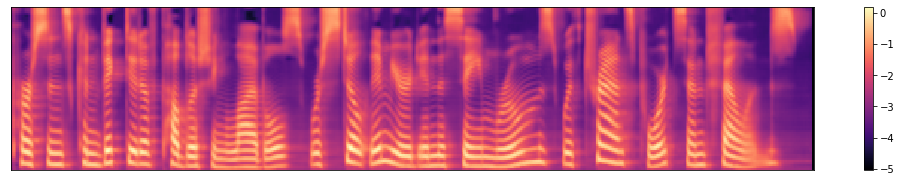

In [10]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time 

for i, batch in enumerate(test_loader):
    batch = to_cuda(batch)
    if i == 80:
        break
print(batch['strings'][0])

model.eval()
with torch.no_grad():
    index = 0
    times = []
    for _ in range(10):
        t0 = time.time()
        samples, time_dict = model.inference(batch['text'][0:1], None, None, temperature=1.0)
        t1 = time.time()
        times.append(t1 - t0)
    times = np.array(times)
    print(samples.shape, np.mean(times))
    print(time_dict)
    
    plt.figure(figsize=[18, 3])
    _x = batch['mels'].data.cpu().numpy()
    _s = samples.data.cpu().numpy()
    librosa.display.specshow(_s[index])
    plt.colorbar()
    plt.show()

In [12]:
vocoder.eval()
with torch.no_grad():
    _mel = _s[0].T
    _mel = (_mel - mean) / scale
    mel = torch.from_numpy(_mel).cuda()
    wav = vocoder.inference(mel)
    _wav = wav[:, 0].data.cpu().numpy()
    print(_wav.shape)
    
import IPython.display as ipd
ipd.Audio(_wav, rate=22050)

(137984,)


0.11256814002990723


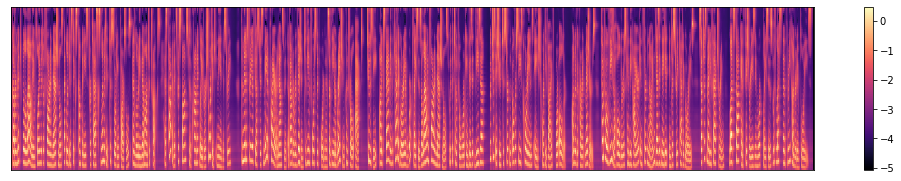

(1050880,)


In [13]:
from g2p_en import G2p

g2p = G2p()

t0 = time.time()
text = "The government will allow the employment of foreign nationals at logistics companies for tasks limited to sorting parcels and loading them onto trucks, as part of its response to the chronic labor shortage in the industry. The Ministry of Justice made a prior announcement about a revision to the enforcement ordinance of the Immigration Control Act, Tuesday, on expanding the category of workplaces allowing foreign nationals with the H-2 working visit visa, which is issued to certain overseas Koreans aged 25 or older. Under the current measures, H-2 visa holders can be hired in 39 designated industry categories, such as manufacturing, livestock and fisheries in workplaces with less than 300 employees."
text_array = g2p(text)
text = ""
for t in text_array:
    text += t

text_utf = text.encode()
ts = [0]
for t in text_utf:
    ts.append(t)
ts.append(0)    
utf8_values = np.array(ts)
t = torch.from_numpy(utf8_values).cuda().unsqueeze(0)
model.eval()
with torch.no_grad():
    
    samples, time_dict = model.inference(t, None, None, temperature=1.0)
    _s = samples.data.cpu().numpy()
    t1 = time.time()
    print(t1 - t0)
    plt.figure(figsize=[18, 3])
    librosa.display.specshow(_s[0])
    plt.colorbar()
    plt.show()

vocoder.eval()
with torch.no_grad():
    _mel = _s[0].T
    _mel = (_mel - mean) / scale
    mel = torch.from_numpy(_mel).cuda()
    wav = vocoder.inference(mel)
    _wav = wav[:, 0].data.cpu().numpy()
    print(_wav.shape)
    
import IPython.display as ipd
ipd.Audio(_wav, rate=22050)